<a href="https://colab.research.google.com/github/Rohitalokjha/DM_PA1/blob/main/ReUpload_PA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment-4 (Data Mining)
                                -Alok Kumar Jha
Dataste used: 4-class dog dataset assigned to you in Assignment 1

## Imported Libraries

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering

## Loading Dataset

In [4]:
from google.colab import drive

drive.mount('/content/drive')
data = '/content/drive/MyDrive/Images'

dataset = [folder for folder in os.listdir(data) if os.path.isdir(os.path.join(data, folder))]
img_files = [f for f in os.listdir(data) if f.endswith(('.jpg', '.png', '.jpeg'))]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Feature Extraction


In [5]:
transform_for_stats = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [52]:
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [53]:
model = models.resnet18(pretrained=True)
model.eval()

model = torch.nn.Sequential(*(list(model.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
all_features = []
all_labels = []

In [55]:
for label, dog_breed_folder in enumerate(dataset):
    folder_path = os.path.join(data, str(dog_breed_folder))

    img_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    print(f"Processing {len(img_files)} images in folder {dog_breed_folder}")

    for img_file in img_files:
        img_path = os.path.join(folder_path, img_file)

        img = Image.open(img_path).convert("RGB")

        normalized_img = transform_for_stats(img)

        with torch.no_grad():
            features = model(normalized_img.unsqueeze(0)).squeeze().numpy()

        all_features.append(features)
        all_labels.append(label)

Processing 150 images in folder Welsh_springer_spaniel
Processing 179 images in folder Kerry_blue_terrier
Processing 178 images in folder malamute
Processing 152 images in folder German_short-haired_pointer


In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_features_normalized = scaler.fit_transform(all_features)

In [57]:
print("Original Features shape:", np.array(all_features).shape)
print("Labels shape:", np.array(all_labels).shape)


Original Features shape: (659, 512)
Labels shape: (659,)


### Reference: https://kozodoi.me/blog/20210527/extracting-features

Reference: https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html


## Dimension Reduction

In [58]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_features_normalized)

In [59]:
print("Reduced Features shape:", reduced_features.shape)

Reduced Features shape: (659, 2)


## Clustering Algorithm

In [60]:
#K-mean clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(reduced_features)

In [61]:
# Fowlkes-Mallows index
fm_index = fowlkes_mallows_score(all_labels, kmeans_labels)

In [62]:
# Silhouette Coefficient
silhouette_coefficient = silhouette_score(reduced_features, kmeans_labels)

In [63]:
print("Fowlkes-Mallows Index:", fm_index)
print("Silhouette Coefficient:", silhouette_coefficient)

Fowlkes-Mallows Index: 0.631964714349626
Silhouette Coefficient: 0.4831081018412747


In [64]:
# (a) K-means clustering with init = 'Random'
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42, n_init=10)
kmeans_labels_random = kmeans_random.fit_predict(reduced_features)

In [65]:
# (b) KMeans with init='k-means++'
kmeans_kmeanspp = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
kmeans_labels_kmeanspp = kmeans_kmeanspp.fit_predict(reduced_features)

In [66]:
# (c) Bisecting K-means
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42, n_init=10)
bisecting_labels = bisecting_kmeans.fit_predict(reduced_features)

In [67]:
# (d) Spectral Clustering with default parameters
spectral_clustering = SpectralClustering(n_clusters=4, random_state=42, n_init=10)
spectral_labels = spectral_clustering.fit_predict(reduced_features)

## DBSCAN

In [68]:
#DBSCAN
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(reduced_features)
distances, indices = neighbors_fit.kneighbors(reduced_features)

In [69]:
eps_value = 0.9
min_samples_value = 7

The eps and min samples parameter values you used to get 4 clusters are:
eps = 0.9
min_sample_value = 7

In [70]:
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan.fit_predict(reduced_features)

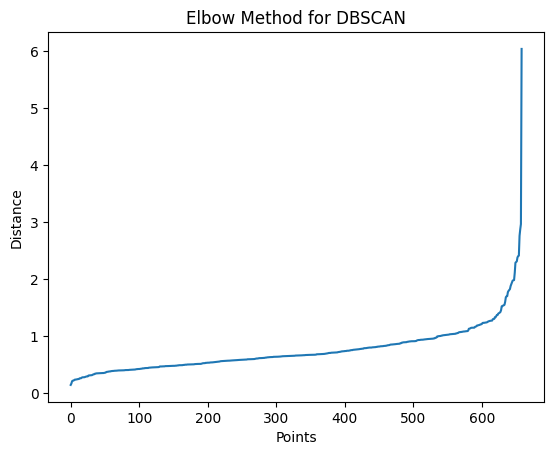

In [71]:
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Elbow Method for DBSCAN")
plt.show()

## Agglomerative Clustering

In [72]:
# Single Link
agglomerative_single = AgglomerativeClustering(n_clusters=4, linkage='single')
agglomerative_labels_single = agglomerative_single.fit_predict(reduced_features)

In [73]:
# Complete Link
agglomerative_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
agglomerative_labels_complete = agglomerative_complete.fit_predict(reduced_features)

In [74]:
# Group Average
agglomerative_average = AgglomerativeClustering(n_clusters=4, linkage='average')
agglomerative_labels_average = agglomerative_average.fit_predict(reduced_features)

In [75]:
# Ward's Method
agglomerative_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglomerative_labels_ward = agglomerative_ward.fit_predict(reduced_features)

## Clustering Evaluations
For all the methods in Item 3:

In [76]:
fowlkes_mallows_random = fowlkes_mallows_score(all_labels, kmeans_labels_random)
silhouette_coefficient_random = silhouette_score(reduced_features, kmeans_labels_random)

print("K-means (Random) - Fowlkes-Mallows Index:", fowlkes_mallows_random)
print("K-means (Random) - Silhouette Coefficient:", silhouette_coefficient_random)

K-means (Random) - Fowlkes-Mallows Index: 0.6338949539099062
K-means (Random) - Silhouette Coefficient: 0.4831222656016943


In [77]:
fowlkes_mallows_kmeanspp = fowlkes_mallows_score(all_labels, kmeans_labels_kmeanspp)
silhouette_coefficient_kmeanspp = silhouette_score(reduced_features, kmeans_labels_kmeanspp)

print("K-means (K-means++) - Fowlkes-Mallows Index:", fowlkes_mallows_kmeanspp)
print("K-means (K-means++) - Silhouette Coefficient:", silhouette_coefficient_kmeanspp)

K-means (K-means++) - Fowlkes-Mallows Index: 0.631964714349626
K-means (K-means++) - Silhouette Coefficient: 0.4831081018412747


In [78]:
fowlkes_mallows_bisecting = fowlkes_mallows_score(all_labels, bisecting_labels)
silhouette_coefficient_bisecting = silhouette_score(reduced_features, bisecting_labels)

print("Bisecting K-means - Fowlkes-Mallows Index:", fowlkes_mallows_bisecting)
print("Bisecting K-means - Silhouette Coefficient:", silhouette_coefficient_bisecting)

Bisecting K-means - Fowlkes-Mallows Index: 0.7195743250790216
Bisecting K-means - Silhouette Coefficient: 0.4386368373705722


In [79]:
fowlkes_mallows_spectral = fowlkes_mallows_score(all_labels, spectral_labels)
silhouette_coefficient_spectral = silhouette_score(reduced_features, spectral_labels)

print("Spectral Clustering - Fowlkes-Mallows Index:", fowlkes_mallows_spectral)
print("Spectral Clustering - Silhouette Coefficient:", silhouette_coefficient_spectral)

Spectral Clustering - Fowlkes-Mallows Index: 0.5661418437635031
Spectral Clustering - Silhouette Coefficient: 0.4595062217883077


In [80]:
# Evaluate Agglomerative Clustering
fowlkes_mallows_agglomerative_single = fowlkes_mallows_score(all_labels, agglomerative_labels_single)
silhouette_coefficient_agglomerative_single = silhouette_score(reduced_features, agglomerative_labels_single)

print("Agglomerative (Single Link) - Fowlkes-Mallows Index:", fowlkes_mallows_agglomerative_single)
print("Agglomerative (Single Link) - Silhouette Coefficient:", silhouette_coefficient_agglomerative_single)

Agglomerative (Single Link) - Fowlkes-Mallows Index: 0.4972691762723401
Agglomerative (Single Link) - Silhouette Coefficient: -0.16831850661529488


In [81]:
fowlkes_mallows_agglomerative_complete = fowlkes_mallows_score(all_labels, agglomerative_labels_complete)
silhouette_coefficient_agglomerative_complete = silhouette_score(reduced_features, agglomerative_labels_complete)

print("Agglomerative (Complete Link) - Fowlkes-Mallows Index:", fowlkes_mallows_agglomerative_complete)
print("Agglomerative (Complete Link) - Silhouette Coefficient:", silhouette_coefficient_agglomerative_complete)

Agglomerative (Complete Link) - Fowlkes-Mallows Index: 0.629403805677919
Agglomerative (Complete Link) - Silhouette Coefficient: 0.4420839397700877


In [82]:
fowlkes_mallows_agglomerative_average = fowlkes_mallows_score(all_labels, agglomerative_labels_average)
silhouette_coefficient_agglomerative_average = silhouette_score(reduced_features, agglomerative_labels_average)

print("Agglomerative (Group Average) - Fowlkes-Mallows Index:", fowlkes_mallows_agglomerative_average)
print("Agglomerative (Group Average) - Silhouette Coefficient:", silhouette_coefficient_agglomerative_average)

Agglomerative (Group Average) - Fowlkes-Mallows Index: 0.6439409243382817
Agglomerative (Group Average) - Silhouette Coefficient: 0.4721621133863082


In [83]:
fowlkes_mallows_agglomerative_ward = fowlkes_mallows_score(all_labels, agglomerative_labels_ward)
silhouette_coefficient_agglomerative_ward = silhouette_score(reduced_features, agglomerative_labels_ward)

print("Agglomerative (Ward's Method) - Fowlkes-Mallows Index:", fowlkes_mallows_agglomerative_ward)
print("Agglomerative (Ward's Method) - Silhouette Coefficient:", silhouette_coefficient_agglomerative_ward)

Agglomerative (Ward's Method) - Fowlkes-Mallows Index: 0.6231226528548729
Agglomerative (Ward's Method) - Silhouette Coefficient: 0.4400715789953832


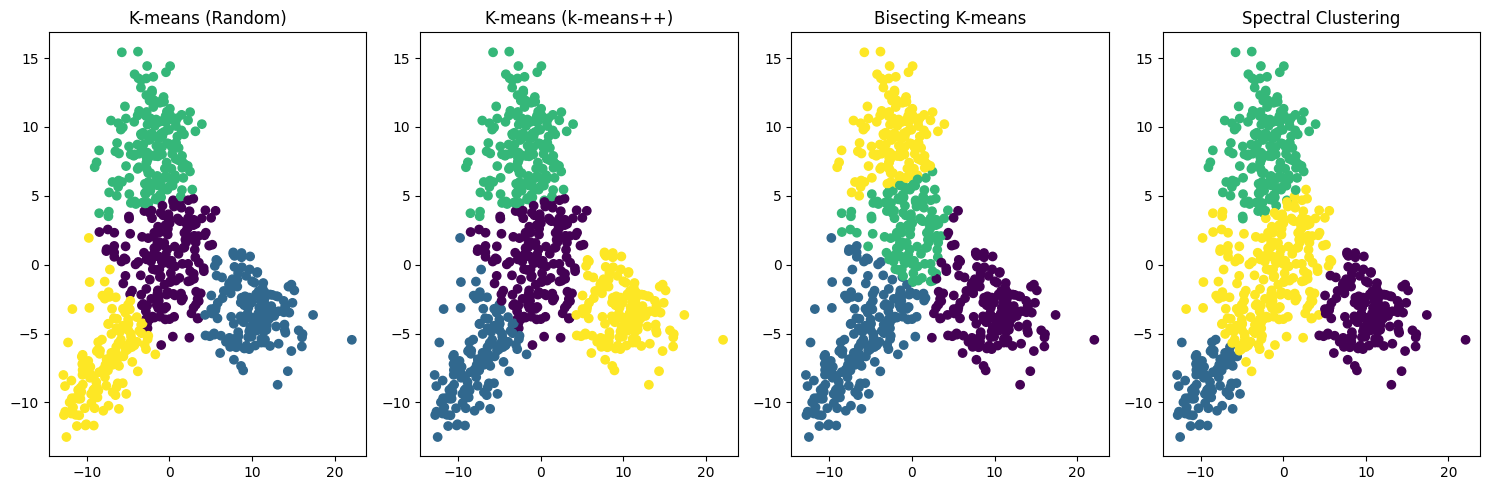

In [84]:
# Visualizing the clusters

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels_random, cmap='viridis', marker='o')
plt.title('K-means (Random)')

plt.subplot(1, 4, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels_kmeanspp, cmap='viridis', marker='o')
plt.title('K-means (k-means++)')

plt.subplot(1, 4, 3)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=bisecting_labels, cmap='viridis', marker='o')
plt.title('Bisecting K-means')

plt.subplot(1, 4, 4)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=spectral_labels, cmap='viridis', marker='o')
plt.title('Spectral Clustering')

plt.tight_layout()
plt.show()

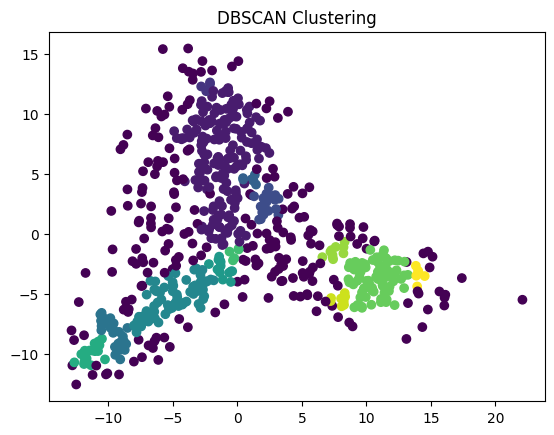

In [85]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.show()

Reference: https://scikit-learn.org/stable/visualizations.html#available-plotting-utilities

In [86]:
# (a) Perform clustering performance evaluation using Fowlkes-Mallows index
fowlkes_mallows_scores = {
    'K-means (Random)': fowlkes_mallows_score(all_labels, kmeans_labels_random),
    'K-means (K-means++)': fowlkes_mallows_score(all_labels, kmeans_labels_kmeanspp),
    'Bisecting K-means': fowlkes_mallows_score(all_labels, bisecting_labels),
    'Spectral Clustering': fowlkes_mallows_score(all_labels, spectral_labels),
    'DBSCAN': fowlkes_mallows_score(all_labels, dbscan_labels),
    'Agglomerative (Single Link)': fowlkes_mallows_score(all_labels, agglomerative_labels_single),
    'Agglomerative (Complete Link)': fowlkes_mallows_score(all_labels, agglomerative_labels_complete),
    'Agglomerative (Group Average)': fowlkes_mallows_score(all_labels, agglomerative_labels_average),
    "Agglomerative (Ward's Method)": fowlkes_mallows_score(all_labels, agglomerative_labels_ward),
}

In [87]:
print("Fowlkes-Mallows Scores:")
for method, score in fowlkes_mallows_scores.items():
    print(f"{method}: {score}")

Fowlkes-Mallows Scores:
K-means (Random): 0.6338949539099062
K-means (K-means++): 0.631964714349626
Bisecting K-means: 0.7195743250790216
Spectral Clustering: 0.5661418437635031
DBSCAN: 0.3940462919273569
Agglomerative (Single Link): 0.4972691762723401
Agglomerative (Complete Link): 0.629403805677919
Agglomerative (Group Average): 0.6439409243382817
Agglomerative (Ward's Method): 0.6231226528548729


In [88]:
# (b) Perform clustering performance evaluation using Silhouette Coefficient
silhouette_scores = {
    'K-means (Random)': silhouette_score(reduced_features, kmeans_labels_random),
    'K-means (K-means++)': silhouette_score(reduced_features, kmeans_labels_kmeanspp),
    'Bisecting K-means': silhouette_score(reduced_features, bisecting_labels),
    'Spectral Clustering': silhouette_score(reduced_features, spectral_labels),
    'DBSCAN': silhouette_score(reduced_features, dbscan_labels),
    'Agglomerative (Single Link)': silhouette_score(reduced_features, agglomerative_labels_single),
    'Agglomerative (Complete Link)': silhouette_score(reduced_features, agglomerative_labels_complete),
    'Agglomerative (Group Average)': silhouette_score(reduced_features, agglomerative_labels_average),
    "Agglomerative (Ward's Method)": silhouette_score(reduced_features, agglomerative_labels_ward),
}

In [89]:
print("Silhouette Scores:")
for method, score in silhouette_scores.items():
    print(f"{method}: {score}")

Silhouette Scores:
K-means (Random): 0.4831222656016943
K-means (K-means++): 0.4831081018412747
Bisecting K-means: 0.4386368373705722
Spectral Clustering: 0.4595062217883077
DBSCAN: -0.2011096427724832
Agglomerative (Single Link): -0.16831850661529488
Agglomerative (Complete Link): 0.4420839397700877
Agglomerative (Group Average): 0.4721621133863082
Agglomerative (Ward's Method): 0.4400715789953832


In [90]:
# (c) Rank the methods based on Fowlkes-Mallows index
ranked_methods_fm = sorted(fowlkes_mallows_scores.keys(), key=lambda x: fowlkes_mallows_scores[x], reverse=True)

In [93]:
print("Ranked Methods based on Fowlkes-Mallows Index:")
for i, method in enumerate(ranked_methods_fm, 1):
    print(f"{i}. {method}")

Ranked Methods based on Fowlkes-Mallows Index:
1. Bisecting K-means
2. Agglomerative (Group Average)
3. K-means (Random)
4. K-means (K-means++)
5. Agglomerative (Complete Link)
6. Agglomerative (Ward's Method)
7. Spectral Clustering
8. Agglomerative (Single Link)
9. DBSCAN


In [94]:
# (d) Rank the methods based on Silhouette Coefficient
ranked_methods_silhouette = sorted(silhouette_scores.keys(), key=lambda x: silhouette_scores[x], reverse=True)

In [95]:
print("Ranked Methods based on Silhouette Coefficient:")
for i, method in enumerate(ranked_methods_silhouette, 1):
    print(f"{i}. {method}")

Ranked Methods based on Silhouette Coefficient:
1. K-means (Random)
2. K-means (K-means++)
3. Agglomerative (Group Average)
4. Spectral Clustering
5. Agglomerative (Complete Link)
6. Agglomerative (Ward's Method)
7. Bisecting K-means
8. Agglomerative (Single Link)
9. DBSCAN


Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html